# U-Net for cell segmentation
---
## Introduction
This is a notebook that shows how to design and train a [U-Net](https://en.wikipedia.org/wiki/U-Net)-like network to segment cells in Phase Contrast Microscopy images using Keras and Tensorflow. The aim is to train the network using original phase contrast microscopy images as input, and one label image per category (background, foreground and contours) as output.

<figure>
<center>
<img src="https://drive.google.com/uc?id=18-cP68ms6vg42V2EHzheTatuJLQ0sJJz" width="750">
</figure>

The resulting model will be downloaded in a format compatible with [DeepImageJ](https://deepimagej.github.io/deepimagej/index.html) so it can be easily executed in Fiji/ImageJ.

**Authors**: [Daniel Franco-Barranco](https://danifranco.github.io), [Ignacio Arganda-Carreras](https://sites.google.com/site/iargandacarreras/), [Estibaliz Gómez-de-Mariscal](https://image.hggm.es/es/estibaliz-gomez) and [Arrate Muñoz-Barrutia](https://image.hggm.es/es/arrate-munoz).

## Data
The image data used in the notebook was provided by Dr. T. Becker. Fraunhofer Institution for Marine Biotechnology, Lübeck, Germany to the [Cell Tracking Challenge](http://celltrackingchallenge.net/). The acquisition details can be found [here](http://celltrackingchallenge.net/2d-datasets/#bg-showmore-hidden-5ea69464435099020168051).
The training data set consists of 2D images of pancreatic stem cells on a polystyrene substrate. The field of view measures 1152 x 922 microns approx., with a resolution of 1.6 x 1.6 um/pixel. In this notebook we will use the gold reference tracking annotations (ST) of the training data (frames 150-250 of both videos). The annotations were binarized for this use-case. Find the data adapted for this notebook [here](https://github.com/esgomezm/NEUBIAS_chapter_DL_2020/releases/download/1/data4notebooks.zip): 

Frames of sequence 01 were used as training data and frames of the sequence 02 were used validation (frames 150, 140, 150, ..., 250) and test data (frames 151, 152, ..., 248, 249).

The data is organized in different folders as follows:

```
./
    |-- train_input
    |    |      t150.tif
    |    |      ...
    |-- train_binary_masks
    |    |      man_seg150.tif
    |    |        ...
    |-- train_contours
    |    |      man_seg150.png
    |    |        ...
    |-- validation_input
    |    |      t150.tif
    |    |      ...
    |-- validation_binary_masks
    |    |      man_seg150.tif
    |    |        ...
    |-- validation_contours
    |    |      man_seg150.png
    |    |        ...
    |-- test_input
    |    |      t151.tif
    |    |      ...
    |-- test_binary_masks
    |    |      man_seg151.tif
    |    |        ...
    |-- test_contours
    |    |      man_seg151.png
    |    |        ...
```




## Getting started
First, we make sure we are using Tensorflow version compatible with [DeepImageJ](https://deepimagej.github.io/deepimagej/index.html) (<= 1.15).


In [ ]:
# Use Tensorflow and Keras versions compatible with DeepImageJ
%pip install tensorflow-gpu==1.15
%pip install keras==2.2.4

     |████████████████████████████████| 411.5MB 41kB/s 
     |████████████████████████████████| 512kB 32.7MB/s 
     |████████████████████████████████| 3.8MB 41.0MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=893378ed7ee09c9ed9f7628903860a2442145143dd2d3e78e2d7e3475154e6c5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

Next, we download the ZIP file with the image data and unzip it in Google's content. 

In [ ]:
import zipfile

# Download file with image data
!wget 'https://github.com/esgomezm/NEUBIAS_chapter_DL_2020/releases/download/1/data4notebooks.zip'
path2zip= 'data4notebooks.zip'

# Extract locally
with zipfile.ZipFile(path2zip, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

--2020-08-07 06:49:42--  https://www.dropbox.com/s/yc9iifgcz4zieib/data4notebooks.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yc9iifgcz4zieib/data4notebooks.zip [following]
--2020-08-07 06:49:42--  https://www.dropbox.com/s/raw/yc9iifgcz4zieib/data4notebooks.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaba577bc63bfa1863c0c6e2dd1.dl.dropboxusercontent.com/cd/0/inline/A88q0TeLjXc_MYwo0qkE7TAXvhn28TVK8GQBIBWrD-0ibmzI8ga2nxV3-MMgVQjHyDCqkUfTs0WuWsWa9oADzeWQSJjhh7P85CvGblhsLr7j38viK4A3bsEpsrZzFBmbS1U/file# [following]
--2020-08-07 06:49:43--  https://ucaba577bc63bfa1863c0c6e2dd1.dl.dropboxusercontent.com/cd/0/inline/A88q0TeLjXc_MYwo0qkE7TAXvhn28TVK8GQBIBWrD-0ibmzI8ga2nxV3-MMgVQjHyDCqkUfTs0WuWsWa9oADzeWQSJjhh

Now we should be able to read the list of **101 training images**, together with their corresponding binary masks and cell contours.

In [ ]:
import os
# Path to the training images
train_input_path = '/content/dataset/train_input'
train_masks_path = '/content/dataset/train_binary_masks'
train_contours_path = '/content/dataset/train_contours'
# Read the list of file names and sort them to have a match between images and masks
train_input_filenames = [x for x in os.listdir( train_input_path ) if x.endswith(".tif")]
train_input_filenames.sort()
train_masks_filenames = [x for x in os.listdir( train_masks_path ) if x.endswith(".tif")]
train_masks_filenames.sort()
train_contours_filenames = [x for x in os.listdir( train_contours_path ) if x.endswith(".png")]
train_contours_filenames.sort()

print( 'Number of training input images: ' + str( len(train_input_filenames)) )
print( 'Number of training binary mask images: ' + str( len(train_masks_filenames)) )
print( 'Number of training contour images: ' + str( len(train_contours_filenames)) )

Number of training input images: 101
Number of training binary mask images: 101
Number of training contour images: 101


Next, we read all those images into memory and display one with its corresponding labels (masks and countours).


Text(0.5, 1.0, 'Object contour')

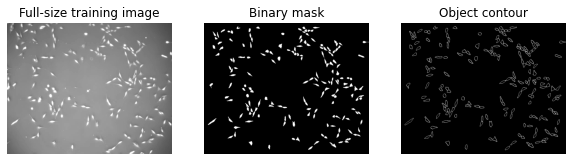

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Read training images (input, mask and contours)
train_img = [cv2.imread(os.path.join(train_input_path, x),
                        cv2.IMREAD_ANYDEPTH) for x in train_input_filenames ]
train_masks = [cv2.imread(os.path.join(train_masks_path, x),
                          cv2.IMREAD_ANYDEPTH)>0 for x in train_masks_filenames ]
train_contours = [cv2.imread(os.path.join(train_contours_path, x),
                             cv2.IMREAD_ANYDEPTH)>0 for x in train_contours_filenames ]

# display the image
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.imshow( train_img[0], 'gray' )
plt.axis('off')
plt.title( 'Full-size training image' )
# its "mask"
plt.subplot(1, 3, 2)
plt.imshow( train_masks[0], 'gray' )
plt.axis('off')
plt.title( 'Binary mask' )
# and cell contours
plt.subplot(1, 3, 3)
plt.imshow( train_contours[0], 'gray' )
plt.axis('off')
plt.title( 'Object contour' )


To facilitate their processing, we concatenate the binary masks and the contours to get one array with the training data.

In [ ]:
import numpy as np
train_output = [np.transpose(np.array([train_masks[i], train_contours[i]]),
                             [1,2,0]) for i in range(len(train_masks))]

Next, we read the 11 images that will be used for validation and inspect some of them visually.

Images loaded: 11


Text(0.5, 1.0, 'Object contour')

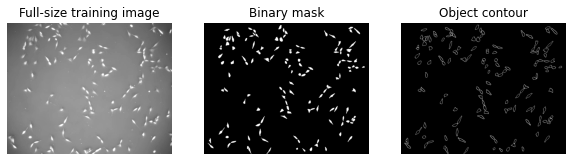

In [ ]:
# Path to the validation images
val_input_path = '/content/dataset/validation_input'
val_masks_path ='/content/dataset/validation_binary_masks'
val_contours_path = '/content/dataset/validation_contours'

# Read the list of file names and sort them to have a match between images and masks
val_input_filenames = [x for x in os.listdir(val_input_path ) if x.endswith(".tif")]
val_input_filenames.sort()
val_masks_filenames = [x for x in os.listdir(val_masks_path ) if x.endswith(".tif")]
val_masks_filenames.sort()
val_contours_filenames = [x for x in os.listdir(val_contours_path ) if x.endswith(".png")]
val_contours_filenames.sort()

print( 'Images loaded: ' + str( len(val_input_filenames)) )

# Read training images
val_img = [cv2.imread(os.path.join(val_input_path, x), cv2.IMREAD_ANYDEPTH) for x in val_input_filenames ]
val_masks = [cv2.imread(os.path.join(val_masks_path, x), cv2.IMREAD_ANYDEPTH)>0 for x in val_masks_filenames ]
val_contours = [cv2.imread(os.path.join(val_contours_path, x), cv2.IMREAD_ANYDEPTH)>0 for x in val_contours_filenames ]

# Display the image
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.imshow(val_img[0], 'gray' )
plt.axis('off')
plt.title( 'Full-size training image' )
# Its "mask"
plt.subplot(1, 3, 2)
plt.imshow(val_masks[0], 'gray' )
plt.axis('off')
plt.title( 'Binary mask' )
# And cell contours
plt.subplot(1, 3, 3)
plt.imshow(val_contours[0], 'gray' )
plt.axis('off')
plt.title( 'Object contour' )

Again, to facilitate their processing, we concatenate the binary masks and the contours to get one array with the training data.

In [ ]:
# concatenate binary masks and contours
val_output = [np.transpose(np.array([val_masks[i],val_contours[i]]),
                           [1,2,0]) for i in range(len(val_masks))]

## Preparing the training data
Now, we are going to create the training set by randomly cropping the input images (and their corresponding labels) into **patches of 256 x 256 pixels**.

To follow Tensorflow standards, the input and output of the network have to be reshaped to 256 x 256 x 1. Notice both input and ground truth images have their intensities scaled between 0.0 and 1.0.


There are 606 patches to train the network


Text(0.5, 1.0, 'Unique labelling of each pixel (ground truth)')

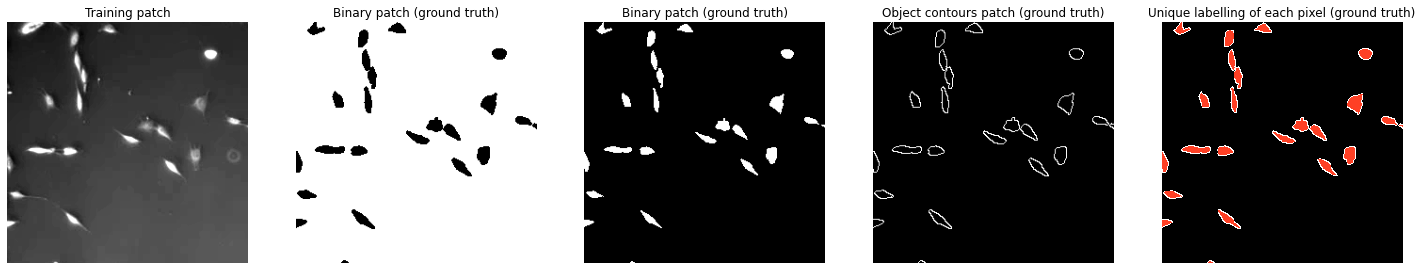

In [ ]:
# Create random patches of 256x256 pixels (of corresponding input and labels,
# i.e. mask and countour image)

import numpy as np

# We define a method to create an arbitrary number of random crops of
# a given size
def create_random_patches( imgs, masks, num_patches, shape ):
    ''' Create a list of images patches out of a list of images
    Args:
        imgs (list): input images.
        masks (list): binary masks (output images) corresponding to imgs.
        num_patches (int): number of patches for each image.
        shape (2D array): size of the patches. Example: [256, 256].
        
    Returns:
        list of image patches and patches of corresponding labels (background,
        foreground and contours)
    '''
    original_size = imgs[0].shape
    
    input_patches = []
    output_patches = []
    for n in range( 0, len( imgs ) ):
        image = imgs[ n ]
        mask = masks[ n ]
        for i in range( num_patches ):
          r = np.random.randint(0,original_size[0]-shape[0])
          c = np.random.randint(0,original_size[1]-shape[1])
          input_patches.append( image[ r : r + shape[0],
                                  c : c + shape[1] ] )
          output_patches.append( mask[ r : r + shape[0],
                                  c : c + shape[1] ] )
    return input_patches, output_patches


# Use the method to create six 256x256 pixel-sized patches per image
train_input_patches, train_output_patches = create_random_patches( train_img, 
                                                                  train_output, 
                                                                  6, [256,256])
print('There are {} patches to train the network'.format(len(train_input_patches)))

# In Y_train we will store the target labels for the network in a one-hot
# fashion, so first channel for background, second for foreground (cells) and
# third one for cell boundaries (contours)
Y_train = [np.stack([1 - x[:,:,0] - x[:,:,1], x[:,:,0], x[:,:,1]],
                    axis=-1) for x in train_output_patches ]
Y_train = np.asarray( Y_train )

# In X_train we will store the input images
X_train = [x/255 for x in train_input_patches] # normalize between 0 and 1
X_train = [np.expand_dims(x, axis=-1) for x in X_train]
X_train = np.asarray(X_train)

# Display one patch
plt.figure(figsize=(25,5))
plt.subplot(1, 5, 1)
plt.imshow( X_train[0,:,:,0], 'gray' )
plt.axis('off')
plt.title( 'Training patch' )
# Background class
plt.subplot(1, 5, 2)
plt.imshow( Y_train[0,:,:,0], 'gray' )
plt.axis('off')
plt.title( 'Binary patch (ground truth)' )
# Foreground class
plt.subplot(1, 5, 3)
plt.imshow( Y_train[0,:,:,1], 'gray' )
plt.axis('off')
plt.title( 'Binary patch (ground truth)' )
# Object contours
plt.subplot(1, 5, 4)
plt.imshow( Y_train[0,:,:,2], 'gray' )
plt.axis('off')
plt.title( 'Object contours patch (ground truth)' )
# Reversed one hot representation
plt.subplot(1, 5, 5)
plt.imshow( np.argmax(Y_train[0], axis = -1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Unique labelling of each pixel (ground truth)' )

And now we do the same for the validation images:

There are 66 patches to validate the network


Text(0.5, 1.0, 'Unique labelling of each pixel (ground truth)')

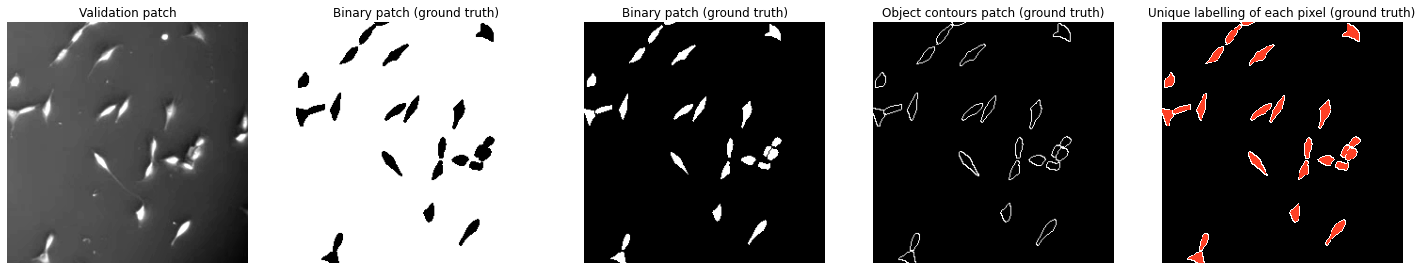

In [ ]:
# We first create the validation patches
val_input_patches, val_output_patches = create_random_patches( val_img, val_output,
                                                              6, [256,256])
print('There are {} patches to validate the network'.format(len(val_input_patches)))

# In Y_val we will store the one-hot respresentation of the labels
Y_val = [np.stack([1 - x[:,:,0] - x[:,:,1], x[:,:,0], x[:,:,1]],
                  axis=-1) for x in val_output_patches ]
Y_val = np.asarray(Y_val)
# In X_val we store the input patches of the validation set
X_val = [x/255 for x in val_input_patches] # normalize between 0 and 1
X_val = [np.expand_dims(x, axis=-1) for x in X_val]
X_val = np.asarray(X_val)

# Display one patch
plt.figure(figsize=(25,5))
plt.subplot(1, 5, 1)
plt.imshow( X_val[0,:,:,0], 'gray' )
plt.axis('off')
plt.title( 'Validation patch' )
# Background class
plt.subplot(1, 5, 2)
plt.imshow( Y_val[0,:,:,0], 'gray' )
plt.axis('off')
plt.title( 'Binary patch (ground truth)' )
# Foreground class
plt.subplot(1, 5, 3)
plt.imshow( Y_val[0,:,:,1], 'gray' )
plt.axis('off')
plt.title( 'Binary patch (ground truth)' )
# Object contours
plt.subplot(1, 5, 4)
plt.imshow( Y_val[0,:,:,2], 'gray' )
plt.axis('off')
plt.title( 'Object contours patch (ground truth)' )
# Reversed one hot representation
plt.subplot(1, 5, 5)
plt.imshow( np.argmax(Y_val[0], axis = -1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Unique labelling of each pixel (ground truth)' )

## Custom segmentation metric: Jaccard index
We define as well the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) (also known as Intersection over the Union or IoU) to monitor de segmentation performance.

**Note**: by default we skip the background label in the calculation since most of the pixels are background and the metric value would be artificially high otherwise.

In [ ]:
import tensorflow as tf

def jaccard_index( y_true, y_pred, skip_background=True ):
    ''' Define Jaccard index for multiple labels.
        Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.
            skip_background (bool, optional): skip 0-label from calculation.
        Return:
            jac (tensor): Jaccard index value
    '''
    # We read the number of classes from the last dimension of the true labels
    num_classes = tf.shape(y_true)[-1]
    # One_hot representation of predicted segmentation after argmax
    y_pred_ = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes)
    y_pred_ = tf.cast(y_pred_, dtype=tf.int32)
    # y_true is already one-hot encoded
    y_true_ = tf.cast(y_true, dtype=tf.int32)
    # Skip background pixels from the Jaccard index calculation
    if skip_background:
      y_true_ = y_true_[...,1:]
      y_pred_ = y_pred_[...,1:]

    TP = tf.math.count_nonzero(y_pred_ * y_true_)
    FP = tf.math.count_nonzero(y_pred_ * (y_true_ - 1))
    FN = tf.math.count_nonzero((y_pred_ - 1) * y_true_)

    jac = tf.cond(tf.greater((TP + FP + FN), 0), lambda: TP / (TP + FP + FN),
                  lambda: tf.cast(0.000, dtype='float64'))

    return jac

## Network definition
Next, we define our U-Net-like network, with 3 resolution levels in the contracting path, a bottleneck, and 3 resolution levels in the expanding path:

<figure>
<center>
<img src="https://drive.google.com/uc?id=14zaw3eomx_2F__8STpzPaedi_r-gbZYR" width="750">
</figure>



As loss function, since we have more than 2 output classes, we use the categorical cross-entropy (CCE) between the expected and the predicted pixel values, and we also include the Jaccard index as a control metric.


In [ ]:
# Create U-Net for segmentation
import keras
from keras.models import Model
from keras.layers import Input, UpSampling2D
from keras.layers import Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D
from keras.layers import concatenate

# We leave the height and width of the input image as "None" so the network can
# later be used on images of any size.
inputs = Input((None, None, 1))

# Contracting path
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = AveragePooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = AveragePooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.3) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = AveragePooling2D((2, 2)) (c3)

# Bottleneck
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.4) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

# Expanding path
u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.1) (c7)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

# The output will consist of 3 neurons (one per class) with softmax activation
# so they represent probabilities
outputs = Conv2D(3, (1, 1), activation='softmax') (c7)

model = Model(inputs=[inputs], outputs=[outputs])

# Finally compile the model with Adam as optimizer, CCE as loss function and IoU
# as metric
opt = keras.optimizers.Adam(lr=0.0003) # Adam with specified learning rate
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[jaccard_index])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Using TensorFlow backend.





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, None, 1 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 1 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
average

## Training the network
Now we are almost ready to train our network! Some important training parameters to take into account:
*   `Epochs`: which defines the maximum number of epochs the model will be trained. Initially set to 100.
*   `Patience`: number of epochs that produced the monitored quantity (validation Jaccard index) with no improvement after which training will be stopped. Initially set to 50.
*   `Batch size`:  the number of training examples in one forward/backward pass. Initially set to 10.



In [ ]:
from keras.callbacks import EarlyStopping

# Training parameters
numEpochs = 100 # maximum number of epochs to train
patience = 50   # number of epochs to wait before stopping if no improvement
batchSize = 10  # number of samples per batch

# Define early stopper to finish the training when the network does not improve
earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True, 
                             monitor='val_jaccard_index', mode='max')

# Train!
history = model.fit( X_train, Y_train, validation_data = (X_val, Y_val),
                    batch_size = batchSize, epochs=numEpochs,
                    callbacks=[earlystopper])

# Save the model weights to and HDF5 file
model.save_weights( 'unet_pancreatic_cell_segmentation_best.h5' )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 606 samples, validate on 66 samples
Epoch 1/100





606/606 [==============================] - 27s 45ms/step - loss: 0.4661 - jaccard_index: 0.0060 - val_loss: 0.2805 - val_jaccard_index: 0.0027
Epoch 2/100
606/606 [==============================] - 15s 24ms/step - loss: 0.2581 - jaccard_index: 0.3045 - val_loss: 0.1572 - val_jaccard_index: 0.4238
Epoch 3/100
606/606 [==============================] - 15s 25ms/step - loss: 0.1746 - jaccard_index: 0.4395 - val_loss: 0.1277 - val_jaccard_index: 0.4819
Epoch 4/100
606/606 [==============================] - 15s 25ms/step - loss: 0.1530 - jaccard_index: 0.4784 - val_loss: 0.1188 - val_jaccard_index: 0.5175
Epoch 5/100
606/606 [==============================] - 15s 24ms/step - loss: 0.1412 - jaccard_index: 0.5065 - val_loss: 0.1061 - val_jaccard_index: 0.5481
Epoch 6/100
606/606 [==============================] - 15s 25ms/step - loss: 0


We can now plot the loss and metric curves for the training and validation sets.


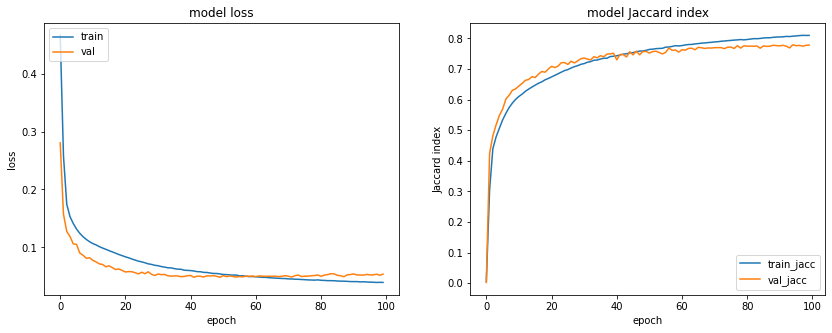

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Summarize history for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Summarize history for Jaccard index
plt.subplot(1, 2, 2)
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('model Jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('epoch')
plt.legend(['train_jacc', 'val_jacc'], loc='lower right')
plt.show()


## Check performance in the test set
Finally we can load some test images for testing.

In [ ]:
# Now we load some unseen images for testing
test_input_path = '/content/dataset/test_input'
test_masks_path ='/content/dataset/test_binary_masks'
test_contours_path = '/content/dataset/test_contours'

test_input_filenames = [x for x in os.listdir( test_input_path ) if x.endswith(".tif")]
test_input_filenames.sort()
test_mask_filenames = [x for x in os.listdir( test_masks_path ) if x.endswith(".tif")]
test_mask_filenames.sort()
test_contours_filenames = [x for x in os.listdir(test_contours_path ) if x.endswith(".png")]
test_contours_filenames.sort()

print( 'Available test images: ' + str( len(test_input_filenames)) )

Available test images: 90


Text(0.5, 1.0, 'Object contour')

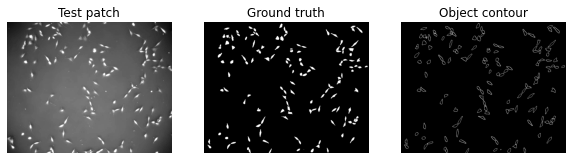

In [ ]:
# Read test images
test_img = [cv2.imread(os.path.join(test_input_path, x),
                       cv2.IMREAD_ANYDEPTH) for x in test_input_filenames ]
test_masks = [cv2.imread(os.path.join(test_masks_path, x),
                         cv2.IMREAD_ANYDEPTH)>0 for x in test_mask_filenames ]
test_contours = [cv2.imread(os.path.join(test_contours_path, x),
                            cv2.IMREAD_ANYDEPTH)>0 for x in test_contours_filenames ]

# Concatenate binary masks and contours
test_output = [np.transpose(np.array([test_masks[i],test_contours[i]]),
                            [1,2,0]) for i in range(len(test_masks))]

# Adapt the test images to an appropriate size using the same function as before
test_input_patches, test_output_patches = create_random_patches( test_img,
                                                                test_output, 1,
                                                                [560,704])

# Display one image
plt.figure(figsize=(10,5))
plt.subplot(1, 3, 1)
plt.imshow( test_input_patches[0], 'gray' )
plt.axis('off')
plt.title( 'Test patch' )
# Its binary mask
plt.subplot(1, 3, 2)
plt.imshow( test_output_patches[0][:,:,0], 'gray' )
plt.axis('off')
plt.title( 'Ground truth' )
# And the object contours
plt.subplot(1, 3, 3)
plt.imshow(test_output_patches[0][:,:,1], 'gray' )
plt.axis('off')
plt.title( 'Object contour' )

We can evaluate the network performance in test using both the CCE and Jaccar index.


In [ ]:
# Evaluate trained network on test images

# Normalize input images
X_test = [x/255 for x in test_input_patches] # normalize between 0 and 1
X_test = [np.expand_dims(x, axis=-1) for x in X_test]
X_test = np.asarray(X_test)

# One-hot label representation
Y_test = [np.stack([1 - x[:,:,0] - x[:,:,1], x[:,:,0], x[:,:,1]],
                   axis=-1) for x in test_output_patches ]
Y_test = np.asarray(Y_test)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(X_test, Y_test, batch_size=1)
print('test loss CCE: {0}, Jaccard index: {1}'.format(results[0], results[1]))



90/90 [==============================] - 11s 118ms/step
test loss CCE: 0.09035193290975359, Jaccard index: 0.7407998955328148


And also display some patches for qualitative evaluation.


# Generate predictions for 3 samples
predictions shape: (1, 560, 704, 3)


Text(0.5, 1.0, 'Zoomed prediction')

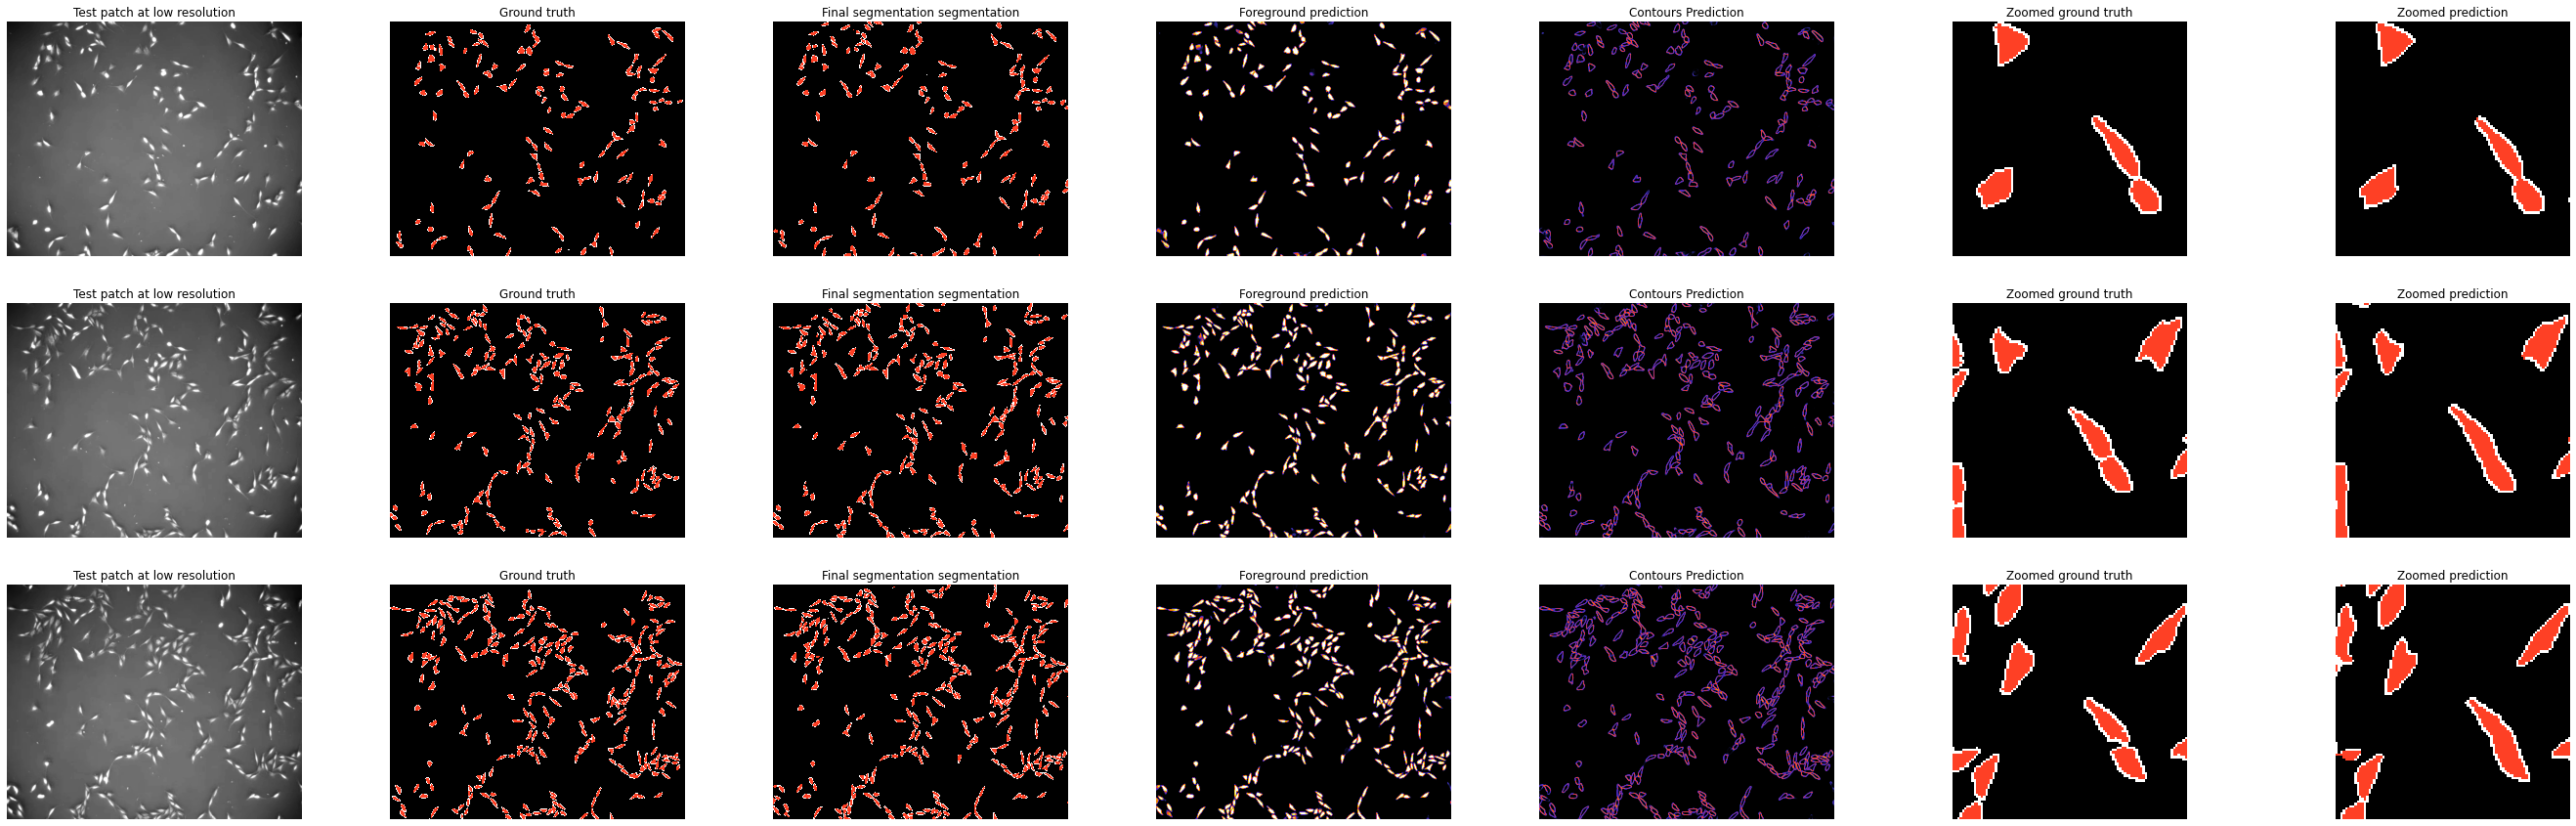

In [ ]:
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:1], batch_size=1)
masks_prediction = np.array((predictions[0,:,:,0], predictions[0,:,:,1]))
contours_prediction = predictions[0,:,:,2]
print('predictions shape:', predictions.shape)

# Display corresponding first 3 patches
plt.figure(figsize=(48,15))
plt.subplot(3, 7, 1)
plt.imshow( test_input_patches[0], 'gray' )
plt.axis('off')
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 7, 2)
plt.imshow( np.argmax(Y_test[0], axis = -1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Ground truth' )
# One hot final segmentation with argmax
plt.subplot(3, 7, 3)
plt.imshow(np.argmax(predictions[0], axis = -1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Final segmentation segmentation' )
# Foreground prediction
plt.subplot(3, 7, 4)
plt.imshow( predictions[0,:,:,1], 'CMRmap')
plt.axis('off')
plt.title( 'Foreground prediction' )
# Contours predictions
plt.subplot(3, 7, 5)
plt.imshow( predictions[0,:,:,2], 'CMRmap')
plt.axis('off')
plt.title( 'Contours Prediction' )
# ZOOM test ground truth
plt.subplot(3, 7, 6)
plt.imshow( np.argmax(Y_test[0,100:200, 100:200], axis=-1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Zoomed ground truth' )
# ZOOM Ground Truth
plt.subplot(3, 7, 7)
plt.imshow( np.argmax(predictions[0][100:200,100:200], axis = -1), 'CMRmap', interpolation='nearest')
plt.axis('off')
plt.title( 'Zoomed prediction' )


predictions = model.predict(np.expand_dims(X_test[50], axis = 0), batch_size=1)

plt.subplot(3, 7, 8)
plt.imshow( test_input_patches[50], 'gray' )
plt.axis('off')
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 7, 9)
plt.imshow( np.argmax(Y_test[50], axis = -1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Ground truth' )
# and one hot final segmentation with argmax
plt.subplot(3, 7, 10)
plt.imshow(np.argmax(predictions[0], axis = -1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Final segmentation segmentation' )
# foreground prediction
plt.subplot(3, 7, 11)
plt.imshow( predictions[0,:,:,1], 'CMRmap')
plt.axis('off')
plt.title( 'Foreground prediction' )
# contours predictions
plt.subplot(3, 7, 12)
plt.imshow( predictions[0,:,:,2], 'CMRmap')
plt.axis('off')
plt.title( 'Contours Prediction' )
# ZOOM test ground truth
plt.subplot(3, 7, 13)
plt.imshow( np.argmax(Y_test[50,100:200, 100:200], axis=-1), 'CMRmap', interpolation='nearest'  )
plt.axis('off')
plt.title( 'Zoomed ground truth' )
#ZOOM Ground Truth
plt.subplot(3, 7, 14)
plt.imshow( np.argmax(predictions[0][100:200,100:200], axis = -1), 'CMRmap', interpolation='nearest')
plt.axis('off')
plt.title( 'Zoomed prediction' )

predictions = model.predict(np.expand_dims(X_test[80], axis = 0), batch_size=1)

plt.subplot(3, 7, 15)
plt.imshow( test_input_patches[80], 'gray' )
plt.axis('off')
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 7, 16)
plt.imshow( np.argmax(Y_test[80], axis = -1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Ground truth' )
# and one hot final segmentation with argmax
plt.subplot(3, 7, 17)
plt.imshow(np.argmax(predictions[0], axis = -1), 'CMRmap', interpolation='nearest' )
plt.axis('off')
plt.title( 'Final segmentation segmentation' )
# foreground prediction
plt.subplot(3, 7, 18)
plt.imshow( predictions[0,:,:,1], 'CMRmap')
plt.axis('off')
plt.title( 'Foreground prediction' )
# contours predictions
plt.subplot(3, 7, 19)
plt.imshow( predictions[0,:,:,2], 'CMRmap')
plt.axis('off')
plt.title( 'Contours Prediction' )
# ZOOM test ground truth
plt.subplot(3, 7, 20)
plt.imshow( np.argmax(Y_test[80,100:200, 100:200], axis=-1), 'CMRmap', interpolation='nearest')
plt.axis('off')
plt.title( 'Zoomed ground truth' )
#ZOOM Ground Truth
plt.subplot(3, 7, 21)
plt.imshow( np.argmax(predictions[0][100:200,100:200], axis = -1), 'CMRmap', interpolation='nearest')
plt.axis('off')
plt.title( 'Zoomed prediction' )

## Save model to import it later in DeepImageJ
Now, we will see how to saved the train model into a file so we can later reuse it in the [DeepImageJ plugin](https://deepimagej.github.io/deepimagej/index.html).

In [ ]:
# Save entire model to the Tensorflow format SavedModel

import tensorflow as tf
import keras
from keras import backend as K
# Load the weights of the model with the best performance in the validation set.
model.load_weights('unet_pancreatic_cell_segmentation_best.h5')

OUTPUT_DIR = "DeepImageJ-model"

builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {'input':  model.input},
            outputs = {'output': model.output})

signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: DeepImageJ-model/saved_model.pb


b'DeepImageJ-model/saved_model.pb'

In [ ]:
model.output

<tf.Tensor 'conv2d_15/truediv:0' shape=(?, ?, ?, 3) dtype=float32>

In [ ]:
# Check if the folder has been properly created
!ls -l

total 47400
-rw-r--r--  1 root root 46522762 Aug  7 06:49 data4notebooks.zip
drwxr-xr-x 11 root root     4096 Aug  7 06:49 dataset
drwxr-xr-x  3 root root     4096 Aug  7 07:15 DeepImageJ-model
drwxr-xr-x  1 root root     4096 Jul 30 16:30 sample_data
-rw-r--r--  1 root root  1996952 Aug  7 07:14 unet_pancreatic_cell_segmentation_best.h5


In [ ]:
# Zip folder with the save model
!zip DeepImageJ-model -r DeepImageJ-model/

  adding: DeepImageJ-model/ (stored 0%)
  adding: DeepImageJ-model/saved_model.pb (deflated 91%)
  adding: DeepImageJ-model/variables/ (stored 0%)
  adding: DeepImageJ-model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: DeepImageJ-model/variables/variables.index (deflated 57%)


In [ ]:
# Check if the file is there
!ls -l

total 52640
-rw-r--r--  1 root root 46522762 Aug  7 06:49 data4notebooks.zip
drwxr-xr-x 11 root root     4096 Aug  7 06:49 dataset
drwxr-xr-x  3 root root     4096 Aug  7 07:15 DeepImageJ-model
-rw-r--r--  1 root root  5363205 Aug  7 07:15 DeepImageJ-model.zip
drwxr-xr-x  1 root root     4096 Jul 30 16:30 sample_data
-rw-r--r--  1 root root  1996952 Aug  7 07:14 unet_pancreatic_cell_segmentation_best.h5


In [ ]:
# And download!
from google.colab import files
files.download("DeepImageJ-model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Appendix: calculate the size of the halo ("padding" value in DeepImageJ).

The halo is determined by the receptive field of one pixel in the image: if there was any kind of padding in the convolutions, then the result for the pixels in the corners is affected by this padding. Thus, we need to determine how far from the edges we need to be, in order to avoid the effect of that padding. This is the same as calculating the receptive field of one pixel to determine the cummulative padding performed along the network architecture. 

Therefore, the halo is exactly the size of this receptive field:

*   Two images that are almost the same are analyzed. The first one is a null image and the second one is a null image with a centered unitary pixel. 

*    When processing both images with the model, it seems that the output is the same. However, when the absolute difference is computed, we can notice that it is only the same in the halo, where the convolutions are influenced by the padding and not the content of the image.

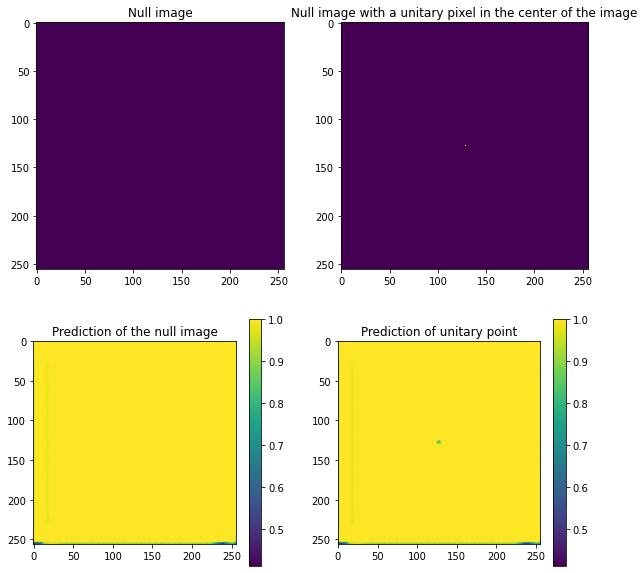

In [ ]:
null_im = np.zeros((1,256,256,1))
point_im = np.zeros_like(null_im)
point_im[0,128,128,0] = 1

result_unit = model.predict(np.concatenate((null_im, point_im)), batch_size=1)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(null_im[0,:,:,0])
plt.title('Null image')

plt.subplot(2,2,2)
plt.imshow(point_im[0,:,:,0])
plt.title('Null image with a unitary pixel in the center of the image')

plt.subplot(2,2,3)
plt.imshow(result_unit[0,:,:,0])
plt.colorbar()
plt.title('Prediction of the null image')

plt.subplot(2,2,4)
plt.imshow(result_unit[1,:,:,0])
plt.colorbar()
plt.title('Prediction of unitary point')
plt.show()

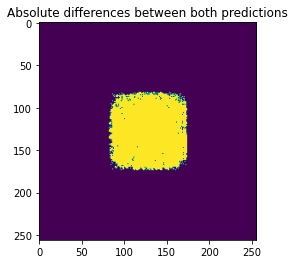

In [ ]:
plt.figure()
D = np.abs(result_unit[0]-result_unit[1])>0
D = D[:,:,0]
plt.imshow(D)
plt.title('Absolute differences between both predictions')
plt.show()

As the kernels in the network are usually squared (size = (3,3)), we just need to measure the halo for one of the axes

In [ ]:
ind = np.where(D[:128,:128]==1)
halo = np.min(ind[1])
print('The size of the halo in this case is {0}'.format(128-halo+1))

The size of the halo in this case is 47
